Running locally at: http://127.0.0.1:7871/
To create a public link, set `share=True` in `launch()`.


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7871/', None)

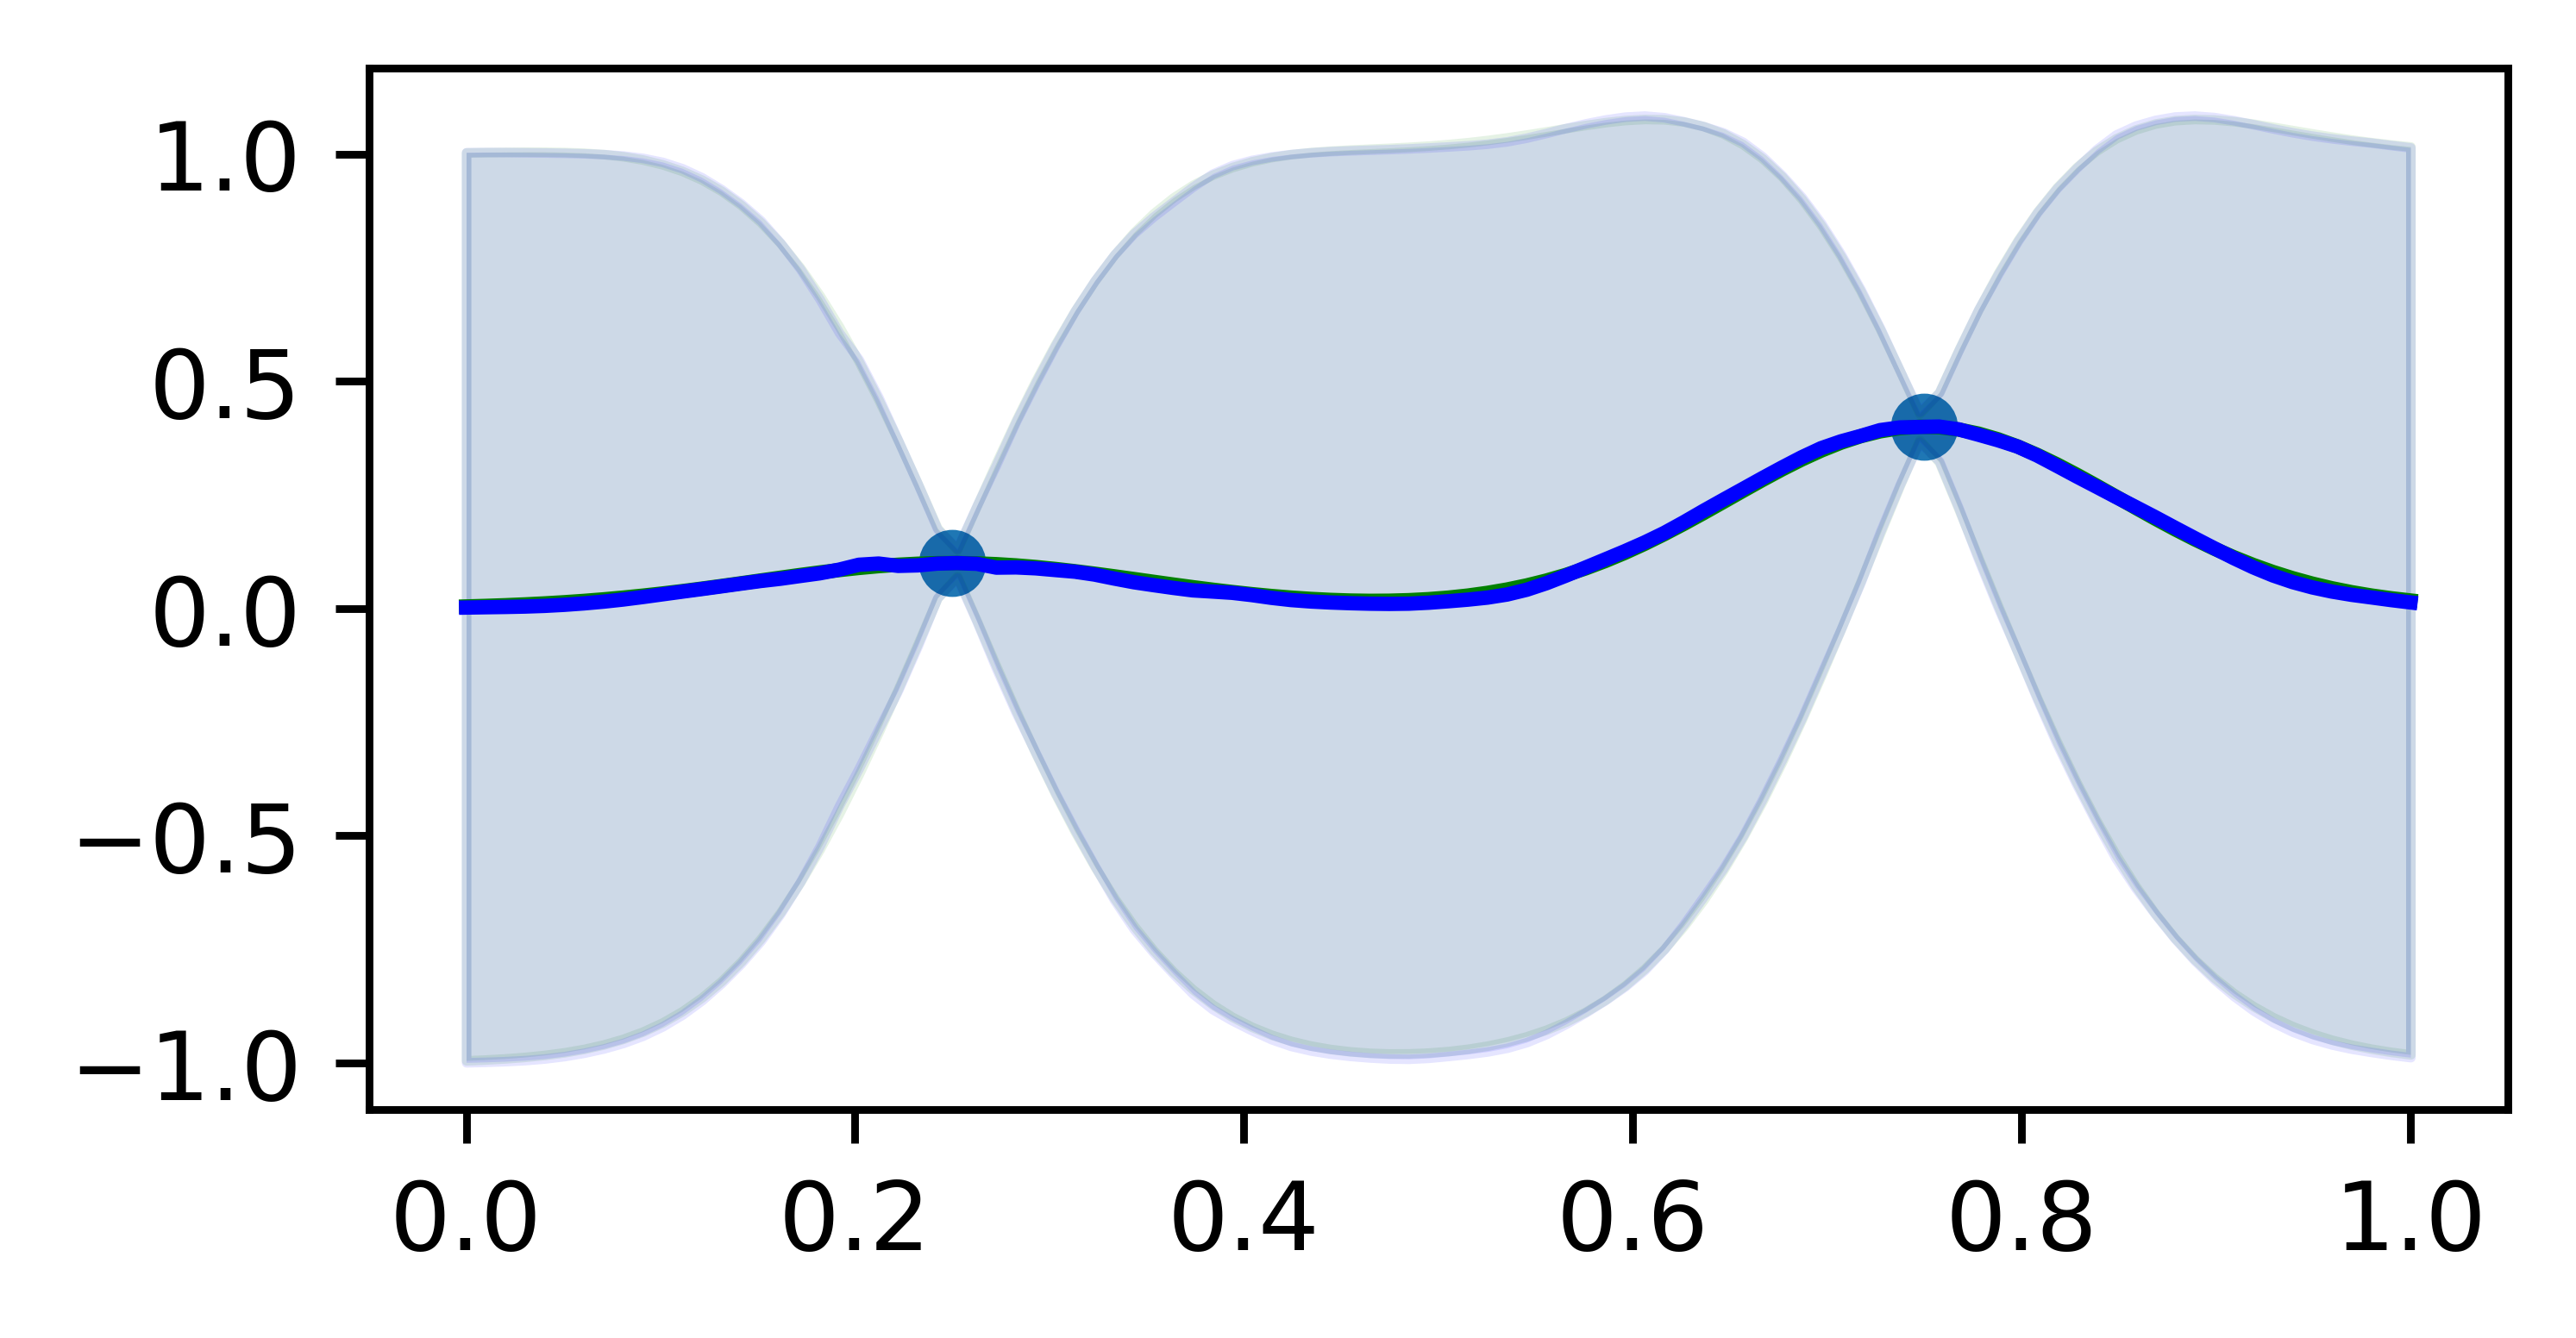

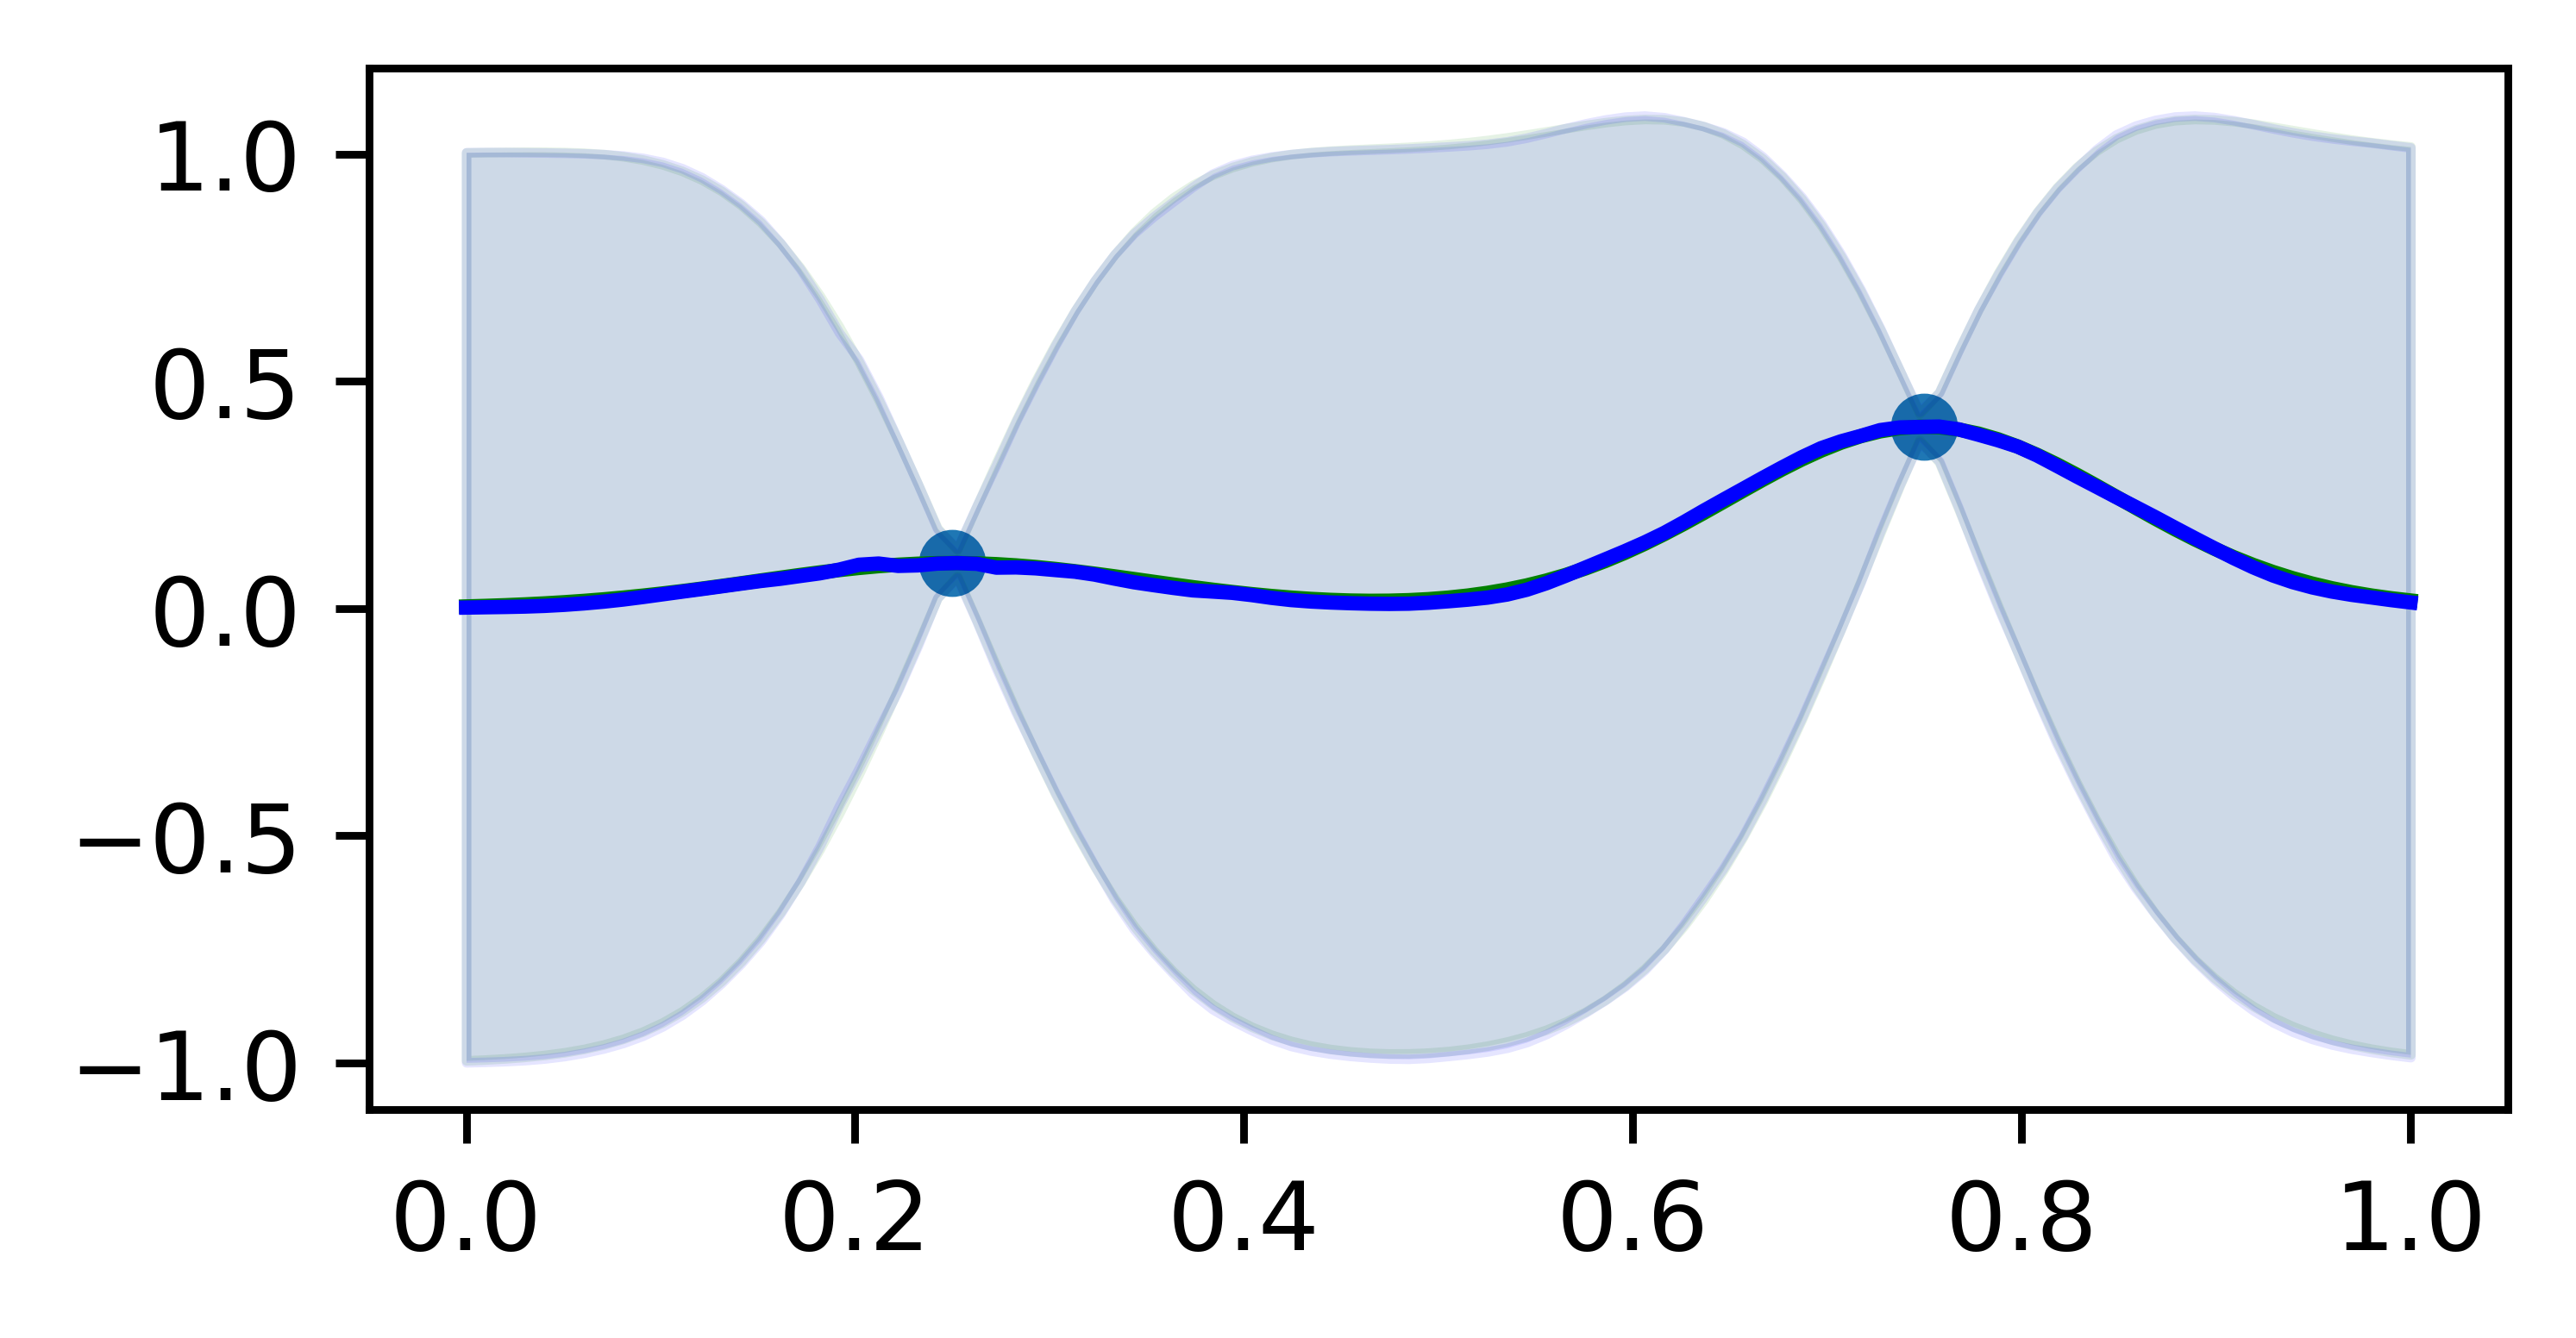

In [13]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import torch
import sys

import gpytorch

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def get_model(x, y, hyperparameters):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1.e-9))
    model = ExactGPModel(x, y, likelihood)
    model.likelihood.noise = torch.ones_like(model.likelihood.noise) * hyperparameters["noise"]
    model.covar_module.outputscale = torch.ones_like(model.covar_module.outputscale) * hyperparameters["outputscale"]
    model.covar_module.base_kernel.lengthscale = torch.ones_like(model.covar_module.base_kernel.lengthscale) * \
                                                 hyperparameters["lengthscale"]
    return model, likelihood



excuse = "Please only specify numbers, x values should be in [0,1] and y values in [-1,1]."
excuse_max_examples = "This model is trained to work with up to 4 input points."
hyperparameters = {'noise': 1e-4, 'outputscale': 1., 'lengthscale': .1, 'fast_computations': (False,False,False)}


conf = .5

def mean_and_bounds_for_gp(x,y,test_xs):
    gp_model, likelihood = get_model(x,y,hyperparameters)
    gp_model.eval()
    l = likelihood(gp_model(test_xs))
    means = l.mean.squeeze()
    varis = torch.diagonal(l.covariance_matrix.squeeze())
    stds = varis.sqrt()
    return means, means-stds, means+stds


def mean_and_bounds_for_pnf(x,y,test_xs, choice):
    sys.path.append('prior-fitting/')
    model = torch.load(f'onefeature_gp_ls.1_pnf_{choice}.pt')

    logits = model((torch.cat([x,test_xs],0).unsqueeze(1),y.unsqueeze(1)),single_eval_pos=len(x))
    bounds = model.criterion.quantile(logits,center_prob=.682).squeeze(1)
    return model.criterion.mean(logits).squeeze(1), bounds[:,0], bounds[:,1]

def plot_w_conf_interval(ax_or_plt, x, m, lb, ub, color):
    ax_or_plt.plot(x.squeeze(-1),m, color=color)
    ax_or_plt.fill_between(x.squeeze(-1), lb, ub, alpha=.1, color=color)




@torch.no_grad()
def infer(table, choice):
    vfunc = np.vectorize(lambda s: len(s))
    non_empty_row_mask = (vfunc(table).sum(1) != 0)
    table = table[non_empty_row_mask]

    try:
        table = table.astype(np.float32)
    except ValueError:
        return excuse, None
    x = torch.tensor(table[:,0]).unsqueeze(1)
    y = torch.tensor(table[:,1])
    fig = plt.figure(figsize=(4,2),dpi=1000)

    if len(x) > 4:
        return excuse_max_examples, None
    if (x<0.).any() or (x>1.).any() or (y<-1).any() or (y>1).any():
        return excuse, None

    plt.scatter(x,y)


    
    test_xs = torch.linspace(0,1,100).unsqueeze(1)
    
    plot_w_conf_interval(plt, test_xs, *mean_and_bounds_for_gp(x,y,test_xs), 'green')
    plot_w_conf_interval(plt, test_xs, *mean_and_bounds_for_pnf(x,y,test_xs, choice), 'blue')


    
    return '', plt.gcf()

iface = gr.Interface(fn=infer,
                     title='GP Posterior Approximation with Transformers',
                     description='''This is a demo of PFNs as we describe them in our recent paper (https://openreview.net/forum?id=KSugKcbNf9).
Lines represent means and shaded areas are the confidence interval (68.2% quantile). In green, we have the ground truth GP posterior and in blue we have our approximation.
We provide three models that are architecturally the same, but with different training budgets.
                     ''',
                     inputs=[
                         gr.inputs.Dataframe(headers=["x", "y"], datatype=["number", "number"], row_count=2, type='numpy', default=[['.25','.1'],['.75','.4']]),
                         gr.inputs.Radio(['160K','800K','4M'], type="value", default='4M', label='Number of Sampled Datasets in Training (Training Costs)')
                     ], outputs=["text","plot"])
iface.launch()



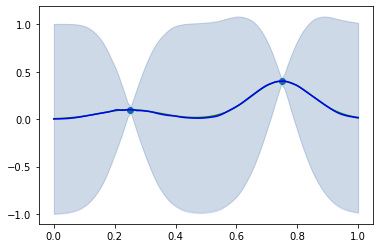

In [3]:
from samlib import notebook_utils
notebook_utils.wide_cells()